## Lab Meeting Analyses

In [3]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
import warnings

from tqdm import tqdm
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from io_utils import *
from plotting_utils import * 


# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")
# sns.set_palette('rocket_r')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sess_names = np.array(['data_sdb_20190724_193007_fromSD', 'data_sdc_20190902_145404_fromSD', 'W122_07_27_2019_1_fromSD', 
            'W122_08_06_2019_1_fromSD', 'W122_08_07_2019_1_fromSD', 'W122_08_31_2019_1_fromSD', 'W122_09_04_2019_1_fromSD',
            'W122_09_09_2019_1_fromSD', 'W122_09_12_2019_1_fromSD','W122_09_21_2019_1_fromSD', 'W122_09_24_2019_1_fromSD'])

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'


# create paths
sess_paths = [os.path.join(base_path, sess) for sess in sess_names]
beh_paths  = [os.path.join(path, beh_mat) for path in sess_paths]
spks_paths = [os.path.join(path, spks_mat) for path in sess_paths]

In [41]:
pal = sns.color_palette('rocket_r', 5)
print(pal.as_hex()[2])

#ca1a50


## Delay Rasters

'data_sdc_20190902_145404_fromSD'

In [13]:
dd = 1

sess_name = sess_names[dd]
sess_path = sess_paths[dd]
beh_path = beh_paths[dd]
spks_path = spks_paths[dd]

beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)
    
filtered_df = beh_df[(beh_df['first_sound'] != 'psycho') & (beh_df['hit_hist'] == 'hit')]

sess_aligned, sess_windows = event_align_session(spks_dict, filtered_df, sess_path, overwrite=True,
                                                delay_mode=True, file_name='labmtg_analysis_delay_hits.pkl')

no file found, running alignment for session


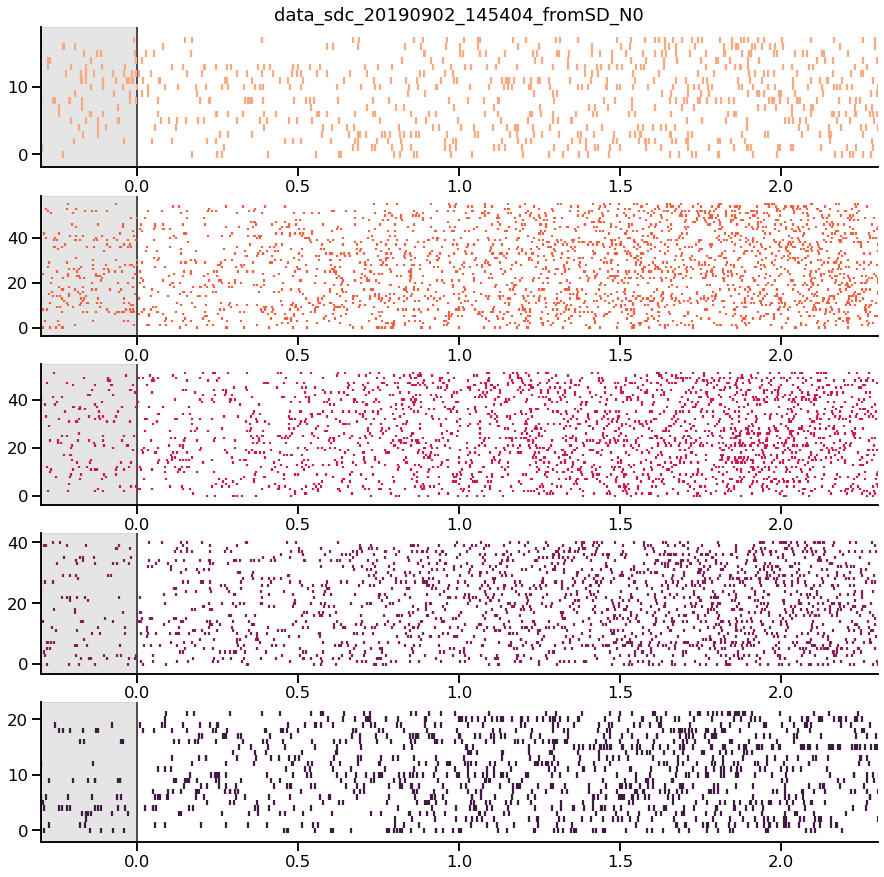

In [44]:
conditions = 'first_sound'
event= 'delay_overlap'
nn = 0
aligned = sess_aligned[nn]
windows = sess_windows[nn]
neuron_id = f"{sess_name}_N{nn}"

trials = dict()

for cond_id in np.sort(filtered_df[conditions].unique()):
    trials[cond_id] = np.where((filtered_df[conditions] == cond_id).values)[0]
    
fig, ax = plt.subplots(len(trials), figsize= (15, 15)) 
c= 0
for cond_id, idxs in trials.items():

    # grab the trials for each condition
    selected_trials = np.array(aligned[event], dtype=object)[idxs]
    
    _ = ax[c].eventplot(selected_trials, colors = delay_colors[c])
    ax[c].axvspan(0,0.000001, color = 'black')
    ax[c].set_xlim(-0.3, 2.3)
    ax[0].set_title(neuron_id)
    ax[c].axvspan(-.3,0, alpha = 0.2, color = 'grey')
    
    c+=1
    
plt.tight_layout
sns.despine()

   

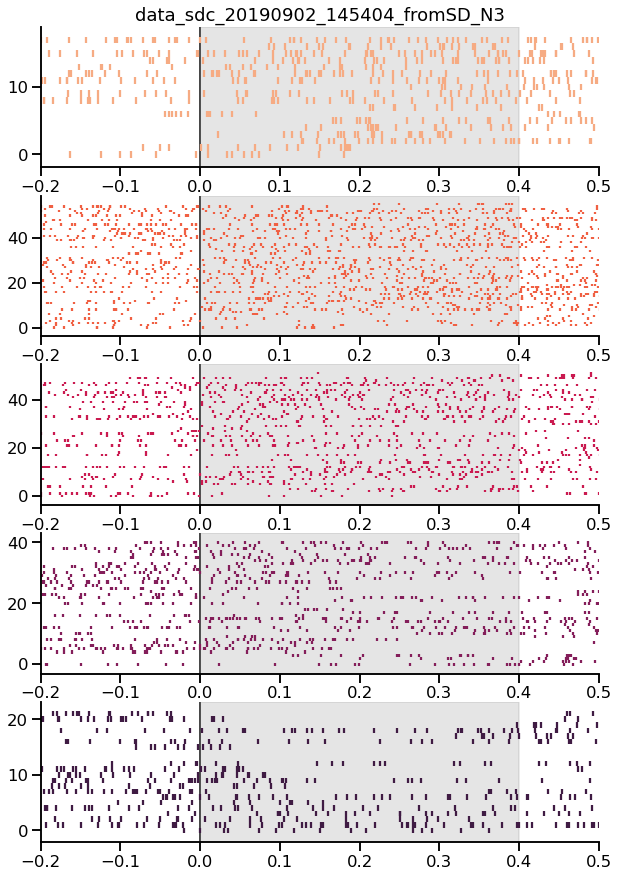

In [49]:
conditions = 'first_sound'
event= 'aud1on'
nn = 3
aligned = sess_aligned[nn]
windows = sess_windows[nn]
neuron_id = f"{sess_name}_N{nn}"

trials = dict()

for cond_id in np.sort(filtered_df[conditions].unique()):
    trials[cond_id] = np.where((filtered_df[conditions] == cond_id).values)[0]
    
fig, ax = plt.subplots(len(trials), figsize= (10, 15)) 
c= 0
for cond_id, idxs in trials.items():

    # grab the trials for each condition
    selected_trials = np.array(aligned[event], dtype=object)[idxs]
    
    _ = ax[c].eventplot(selected_trials, colors = delay_colors[c])
    ax[c].axvspan(0,0.000001, color = 'black')
    ax[c].set_xlim(-0.2, 0.5)
    ax[0].set_title(neuron_id)
    ax[c].axvspan(0,0.4, alpha = 0.2, color = 'grey')
    
    c+=1
    
plt.tight_layout
sns.despine()


## AUD 1 on plots

In [25]:
event = 'aud1on'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'aud1_all')

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    noviol_df = beh_df[beh_df['hit_hist'] != 'viol']
    
    sess_aligned, sess_windows = event_align_session(spks_dict, noviol_df, path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='labmtg_analysis_hit_miss.pkl')
    
    
    for neuron in range(len(sess_aligned)):

        neuron_id = name + '_N' + str(neuron)

        # calculate psth
        psth = PSTH_gaussain(sess_aligned[neuron], sess_windows[neuron], event, noviol_df, sigma=50)

        fig,ax = plt.subplots(figsize=(8,4))

        plot_psth(psth, ax=ax, stimulus_bar='sound on', legend=True, xlim=(-200,500), title=neuron_id)

        fig_name =  f"{neuron_id}_{event}_aud1on_all"
        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")

loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...


Aud1 on split by hit/miss

In [16]:
event = 'aud1on'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'aud1_hit_miss')

lr_pal = ['#5ECABB', '#CA5E6D']
lr_cycler =cycler(color=lr_pal)

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    noviol_df = beh_df[beh_df['hit_hist'] != 'viol']
    
    sess_aligned, sess_windows = event_align_session(spks_dict, noviol_df, path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='labmtg_analysis_hit_miss.pkl')
    
    
    for neuron in range(len(sess_aligned)):

        neuron_id = name + '_N' + str(neuron)

        # calculate psth
        psth = PSTH_gaussain(sess_aligned[neuron], sess_windows[neuron], 
                             event,  noviol_df, 
                             conditions='hit_hist', sigma=50)

        fig,ax = plt.subplots(figsize=(8,4))
        ax.set_prop_cycle(lr_cycler)

        plot_psth(psth, ax=ax, stimulus_bar='sound on', legend=True, 
                  xlim=(-200,500), title=neuron_id)

        fig_name =  f"{neuron_id}_{event}_aud1on_hit_miss"
        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")

loading from file...


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)


loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:365: RuntimeWarning: All-NaN axis encountered
  y_min = (1 - scale) * np.nanmin([np.min(mean[cond_id]) for cond_id in mean.keys()])
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:366: RuntimeWarning: All-NaN axis encountered
  y_max = (1 - scale) * np.nanmax([np.max(mean[cond_id]) for cond_id in mean.keys()])


loading from file...
loading from file...
loading from file...


Aud1 on splity by all first sounds

In [29]:
event = 'aud1on'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'aud1_loudness')

delay_colors =['#f6ab83', '#f06043', '#ca1a50', '#841e5a', '#3f1b43']
delay_colors_edges = [delay_colors[0], delay_colors[-1]]
delay_colors_middle = np.array(delay_colors[1:4])
delay_color = delay_colors
delay_cycler =cycler(color=delay_color)

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    noviol_psycho_df = beh_df[(beh_df['first_sound'] != 'psycho') & (beh_df['hit_hist'] != 'viol')]
    
    sess_aligned, sess_windows = event_align_session(spks_dict, noviol_psycho_df, path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='labmtg_analysis_hit_miss_nopsycho.pkl')
    
    
    for neuron in range(len(sess_aligned)):

        neuron_id = name + '_N' + str(neuron)

        # calculate psth
        psth = PSTH_gaussain(sess_aligned[neuron], sess_windows[neuron], 
                             event, noviol_psycho_df, 
                             conditions='first_sound', sigma=50)

        fig,ax = plt.subplots(figsize=(8,4))
        ax.set_prop_cycle(delay_cycler)

        plot_psth(psth, ax=ax, stimulus_bar='sound on', legend=True, 
                  xlim=(-200,500), title=neuron_id)

        fig_name =  f"{neuron_id}_{event}_aud1on_loudness"
        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")


loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...


Aud 1 on split by 'sure bet' sounds

In [22]:
event = 'aud1on'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'aud1_edge_sounds')
sound_list = ['60*', '92*']

# colors
delay_colors =['#f6ab83', '#f06043', '#ca1a50', '#841e5a', '#3f1b43']
delay_colors_edges = [delay_colors[0], delay_colors[-1]]
delay_colors_middle = np.array(delay_colors[1:4])
delay_color = delay_colors_edges
delay_cycler =cycler(color=delay_color)


for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    
    filtered_df = beh_df[(beh_df['first_sound'].isin(sound_list)) & (beh_df['hit_hist'] == 'hit')]
    
    
    sess_aligned, sess_windows = event_align_session(spks_dict, filtered_df, 
                                                     path, overwrite=False,
                                                     delay_mode=True, 
                                                     file_name='labmtg_analysis_edge_sounds_hit_miss.pkl')

    for neuron in range(len(sess_aligned)):

        neuron_id = name + '_N' + str(neuron)

        # calculate psth
        psth = PSTH_gaussain(sess_aligned[neuron], sess_windows[neuron], 
                             event,  filtered_df, 
                             conditions='first_sound', sigma=50)

        fig,ax = plt.subplots(figsize=(8,4))
        ax.set_prop_cycle(delay_cycler)

        plot_psth(psth, ax=ax, stimulus_bar='sound on', legend=True, 
                  xlim=(-200,500), title=neuron_id)

        fig_name =  f"{neuron_id}_{event}_aud1on_edge_sounds"
        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")

loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...


C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, r

loading from file...
loading from file...
loading from file...


Aud 1 on for files when memory is needed

In [23]:
event = 'aud1on'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'aud1_middle_sounds')
sound_list = ['68', '76', '84']


# colors
delay_colors =['#f6ab83', '#f06043', '#ca1a50', '#841e5a', '#3f1b43']
delay_colors_edges = [delay_colors[0], delay_colors[-1]]
delay_colors_middle = np.array(delay_colors[1:4])
delay_color = delay_colors_middle
delay_cycler =cycler(color=delay_color)


for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    
    filtered_df = beh_df[(beh_df['first_sound'].isin(sound_list)) & (beh_df['hit_hist'] == 'hit')]
    
    
    sess_aligned, sess_windows = event_align_session(spks_dict, filtered_df, 
                                                     path, overwrite=False,
                                                     delay_mode=True, 
                                                     file_name='labmtg_analysis_middle_sounds.pkl')

    for neuron in range(len(sess_aligned)):

        neuron_id = name + '_N' + str(neuron)

        # calculate psth
        psth = PSTH_gaussain(sess_aligned[neuron], sess_windows[neuron], 
                             event,  filtered_df, 
                             conditions='first_sound', sigma=50)

        fig,ax = plt.subplots(figsize=(8,4))
        ax.set_prop_cycle(delay_cycler)

        plot_psth(psth, ax=ax, stimulus_bar='sound on', legend=True, 
                  xlim=(-200,500), title=neuron_id)

        fig_name =  f"{neuron_id}_{event}_aud1on_middle_sounds"
        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")

loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...


## AUD 2 on plots

This is just aud2 on with all the trials together (sans violations)

In [12]:
event = 'aud2on'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'aud2_all')


for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    noviol_df = beh_df[beh_df['hit_hist'] != 'viol']
    
    sess_aligned, sess_windows = event_align_session(spks_dict, noviol_df, path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='labmtg_analysis_hit_miss.pkl')
    
    
    for neuron in range(len(sess_aligned)):

        neuron_id = name + '_N' + str(neuron)

        # calculate psth
        psth = PSTH_gaussain(sess_aligned[neuron], sess_windows[neuron], event, noviol_df, sigma=50)

        fig,ax = plt.subplots(figsize=(8,4))

        plot_psth(psth, ax=ax, stimulus_bar='sound on', legend=False, 
                  xlim=(-200,500), title=neuron_id)

        fig_name =  f"{neuron_id}_{event}_aud2on_all"
        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")

loading from file...


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:365: RuntimeWarning: All-NaN axis encountered
  y_min = (1 - scale) * np.nanmin([np.min(mean[cond_id]) for cond_id in mean.keys()])
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:366: RuntimeWarning: All-NaN axis encountered
  y_max = (1 - scale) * np.nanmax([np.max(mean[cond_id]) for cond_id in mean.keys()])


loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...


Aud 2 on split by correct side

In [13]:
event = 'aud2on'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'aud2_correct_side')

lr_pal = ['#3066C8', '#C89230']
lr_cycler =cycler(color=lr_pal)

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    noviol_df = beh_df[beh_df['hit_hist'] != 'viol']
    
    sess_aligned, sess_windows = event_align_session(spks_dict, noviol_df, path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='labmtg_analysis_hit_miss.pkl')
    
    
    for neuron in range(len(sess_aligned)):

        neuron_id = name + '_N' + str(neuron)

        # calculate psth
        psth = PSTH_gaussain(sess_aligned[neuron], sess_windows[neuron], 
                             event,  noviol_df, 
                             conditions='correct_side', sigma=50)

        fig,ax = plt.subplots(figsize=(8,4))
        ax.set_prop_cycle(lr_cycler)

        plot_psth(psth, ax=ax, stimulus_bar='sound on', legend=True, 
                  xlim=(-200,500), title=neuron_id)

        fig_name =  f"{neuron_id}_{event}_aud2on_correct_side"
        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")

loading from file...


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:365: RuntimeWarning: All-NaN axis encountered
  y_min = (1 - scale) * np.nanmin([np.min(mean[cond_id]) for cond_id in mean.keys()])
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:366: RuntimeWarning: All-NaN axis encountered
  y_max = (1 - scale) * np.nanmax([np.max(mean[cond_id]) for cond_id in mean.keys()])


loading from file...
loading from file...


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)


loading from file...
loading from file...
loading from file...
loading from file...
loading from file...


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)


loading from file...
loading from file...
loading from file...


Aud2 split by hit vs. miss



In [15]:
event = 'aud2on'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'aud2_hit_miss')

lr_pal = ['#5ECABB', '#CA5E6D']
lr_cycler =cycler(color=lr_pal)

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    noviol_df = beh_df[beh_df['hit_hist'] != 'viol']
    
    sess_aligned, sess_windows = event_align_session(spks_dict, noviol_df, path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='labmtg_analysis_hit_miss.pkl')
    
    
    for neuron in range(len(sess_aligned)):

        neuron_id = name + '_N' + str(neuron)

        # calculate psth
        psth = PSTH_gaussain(sess_aligned[neuron], sess_windows[neuron], 
                             event,  noviol_df, 
                             conditions='hit_hist', sigma=50)

        fig,ax = plt.subplots(figsize=(8,4))
        ax.set_prop_cycle(lr_cycler)

        plot_psth(psth, ax=ax, stimulus_bar='sound on', legend=True, 
                  xlim=(-200,500), title=neuron_id)

        fig_name =  f"{neuron_id}_{event}_aud2on_hit_miss"
        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")

loading from file...


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:365: RuntimeWarning: All-NaN axis encountered
  y_min = (1 - scale) * np.nanmin([np.min(mean[cond_id]) for cond_id in mean.keys()])
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:366: RuntimeWarning: All-NaN axis encountered
  y_max = (1 - scale) * np.nanmax([np.max(mean[cond_id]) for cond_id in mean.keys()])


loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...
loading from file...


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)


loading from file...
loading from file...
loading from file...


## firing rate ~ correct side plots

### hit only

In [4]:
event = 'delay_overlap'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'correct_side' )

# gather pvalues for all the sessions to put into single df
session_stats = []

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    print('Loading data ...')
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    
    hit_df = beh_df[beh_df['hit_hist'] == 'hit']
    
    print('aligning events ...')
    sess_aligned, sess_windows = event_align_session(spks_dict, hit_df, path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='labmtg_analysis_hitonly.pkl')
    
    stats = analyze_and_plot_correct_side(name, sess_aligned, sess_windows, event, 
                              hit_df, fig_save_path) 
    
    session_stats.append(stats)

Loading data ...
aligning events ...
loading from file...
Plotting data_sdb_20190724_193007_fromSD_N0
Plotting data_sdb_20190724_193007_fromSD_N1
Plotting data_sdb_20190724_193007_fromSD_N2
Plotting data_sdb_20190724_193007_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting data_sdc_20190902_145404_fromSD_N0
Plotting data_sdc_20190902_145404_fromSD_N1
Plotting data_sdc_20190902_145404_fromSD_N2
Plotting data_sdc_20190902_145404_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_07_27_2019_1_fromSD_N0
Plotting W122_07_27_2019_1_fromSD_N1
Plotting W122_07_27_2019_1_fromSD_N2
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_08_06_2019_1_fromSD_N0
Plotting W122_08_06_2019_1_fromSD_N1
Plotting W122_08_06_2019_1_fromSD_N2
Plotting W122_08_06_2019_1_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plo

In [6]:
session_stats_df = pd.concat(session_stats)
session_stats_df.reset_index().to_csv(os.path.join(fig_save_path, 'correct_side_stats.csv'))

### hit & miss

In [11]:
event = 'delay_overlap'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'correct_side_delay_hitmiss' )

# gather pvalues for all the sessions to put into single df
session_stats = []

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    print('Loading data ...')
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    
    noviol_df = beh_df[beh_df['hit_hist'] != 'viol']
    
    print('aligning events ...')
    sess_aligned, sess_windows = event_align_session(spks_dict, noviol_df, path, 
                                                 overwrite=False, delay_mode=True, 
                                                 file_name='labmtg_analysis_hit_miss.pkl')
    
    stats = analyze_and_plot_correct_side(name, sess_aligned, sess_windows, event, 
                              hit_df, fig_save_path) 
    
    session_stats.append(stats)

Loading data ...
aligning events ...
no file found, running alignment for session
Plotting data_sdb_20190724_193007_fromSD_N0
Plotting data_sdb_20190724_193007_fromSD_N1
Plotting data_sdb_20190724_193007_fromSD_N2
Plotting data_sdb_20190724_193007_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting data_sdc_20190902_145404_fromSD_N0
Plotting data_sdc_20190902_145404_fromSD_N1
Plotting data_sdc_20190902_145404_fromSD_N2
Plotting data_sdc_20190902_145404_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_07_27_2019_1_fromSD_N0
Plotting W122_07_27_2019_1_fromSD_N1
Plotting W122_07_27_2019_1_fromSD_N2
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_08_06_2019_1_fromSD_N0
Plotting W122_08_06_2019_1_fromSD_N1
Plotting W122_08_06_2019_1_fromSD_N2
Plotting W122_08_06_2019_1_fromSD_N3
Loading data ...
aligning events ...
no file found, running a

## firing rate ~ first sound loudness plots

as of 05/16/2021 these may not still work beacuse a sub function switched names, but otherwise should be ok

In [31]:
event = 'delay_overlap'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'delay_loudness_no_masking')

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    print('Loading data ...')
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    
    filtered_df = beh_df[(beh_df['first_sound'] != 'psycho') & (beh_df['hit_hist'] == 'hit')]
    
    print('aligning events ...')
    sess_aligned, sess_windows = event_align_session(spks_dict, filtered_df, path, overwrite=True,
                                                delay_mode=True, file_name='labmtg_analysis.pkl')
    
    analyze_and_plot_loudness(name, sess_aligned, sess_windows, event, filtered_df, fig_save_path, path)

Loading data ...
aligning events ...
no file found, running alignment for session
Plotting data_sdb_20190724_193007_fromSD_N0
Plotting data_sdb_20190724_193007_fromSD_N1
Plotting data_sdb_20190724_193007_fromSD_N2
Plotting data_sdb_20190724_193007_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting data_sdc_20190902_145404_fromSD_N0
Plotting data_sdc_20190902_145404_fromSD_N1
Plotting data_sdc_20190902_145404_fromSD_N2
Plotting data_sdc_20190902_145404_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_07_27_2019_1_fromSD_N0
Plotting W122_07_27_2019_1_fromSD_N1
Plotting W122_07_27_2019_1_fromSD_N2
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_08_06_2019_1_fromSD_N0
Plotting W122_08_06_2019_1_fromSD_N1
Plotting W122_08_06_2019_1_fromSD_N2
Plotting W122_08_06_2019_1_fromSD_N3
Loading data ...
aligning events ...
no file found, running a

C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Plotting W122_09_09_2019_1_fromSD_N1


C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Plotting W122_09_09_2019_1_fromSD_N2


C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_09_12_2019_1_fromSD_N0
Plotting W122_09_12_2019_1_fromSD_N1
Plotting W122_09_12_2019_1_fromSD_N2
Plotting W122_09_12_2019_1_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_09_21_2019_1_fromSD_N0
Plotting W122_09_21_2019_1_fromSD_N1
Plotting W122_09_21_2019_1_fromSD_N2
Plotting W122_09_21_2019_1_fromSD_N3
Plotting W122_09_21_2019_1_fromSD_N4
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_09_24_2019_1_fromSD_N0
Plotting W122_09_24_2019_1_fromSD_N1


In [9]:
event = 'delay_overlap'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'delay_loudness_edge_sounds')
sound_list = ['60*', '92*']

# delay_colors =['#f6ab83', '#f06043', '#ca1a50', '#841e5a', '#3f1b43']
# delay_colors_edges = [delay_colors[0], delay_colors[-1]]


for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    
    filtered_df = beh_df[(beh_df['first_sound'].isin(sound_list)) & (beh_df['hit_hist'] == 'hit')]
    
    
    sess_aligned, sess_windows = event_align_session(spks_dict, filtered_df, 
                                                     path, overwrite=True,
                                                     delay_mode=True, 
                                                     file_name='labmtg_analysis_edge_sounds.pkl')
    
    analyze_and_plot_loudness(name, sess_aligned, 
                              sess_windows, event, filtered_df, 
                              fig_save_path, path)

no file found, running alignment for session
Plotting data_sdb_20190724_193007_fromSD_N0


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  if summary:
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:365: RuntimeWarning: All-NaN axis encountered
  scale = 0.01
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:366: RuntimeWarning: All-NaN axis encountered
  y_min = (1 - scale) * np.nanmin([np.min(mean[cond_id]) for cond_id in mean.keys()])


Plotting data_sdb_20190724_193007_fromSD_N1
Plotting data_sdb_20190724_193007_fromSD_N2
Plotting data_sdb_20190724_193007_fromSD_N3
no file found, running alignment for session
Plotting data_sdc_20190902_145404_fromSD_N0
Plotting data_sdc_20190902_145404_fromSD_N1
Plotting data_sdc_20190902_145404_fromSD_N2
Plotting data_sdc_20190902_145404_fromSD_N3
no file found, running alignment for session
Plotting W122_07_27_2019_1_fromSD_N0
Plotting W122_07_27_2019_1_fromSD_N1


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  if summary:


Plotting W122_07_27_2019_1_fromSD_N2
no file found, running alignment for session
Plotting W122_08_06_2019_1_fromSD_N0
Plotting W122_08_06_2019_1_fromSD_N1
Plotting W122_08_06_2019_1_fromSD_N2
Plotting W122_08_06_2019_1_fromSD_N3
no file found, running alignment for session
Plotting W122_08_07_2019_1_fromSD_N0
Plotting W122_08_07_2019_1_fromSD_N1
Plotting W122_08_07_2019_1_fromSD_N2
Plotting W122_08_07_2019_1_fromSD_N3
Plotting W122_08_07_2019_1_fromSD_N4
Plotting W122_08_07_2019_1_fromSD_N5
no file found, running alignment for session
Plotting W122_08_31_2019_1_fromSD_N0


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  if summary:


Plotting W122_08_31_2019_1_fromSD_N1
Plotting W122_08_31_2019_1_fromSD_N2
Plotting W122_08_31_2019_1_fromSD_N3
no file found, running alignment for session
Plotting W122_09_04_2019_1_fromSD_N0
Plotting W122_09_04_2019_1_fromSD_N1
no file found, running alignment for session
Plotting W122_09_09_2019_1_fromSD_N0


C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Plotting W122_09_09_2019_1_fromSD_N1


C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\JB\anaconda3\envs\PWM_ephys\lib\site-packages\numpy\core\_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Plotting W122_09_09_2019_1_fromSD_N2


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:184: RuntimeWarning: Mean of empty slice
  if summary:
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:365: RuntimeWarning: All-NaN axis encountered
  scale = 0.01
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:366: RuntimeWarning: All-NaN axis encountered
  y_min = (1 - scale) * np.nanmin([np.min(mean[cond_id]) for cond_id in mean.keys()])


no file found, running alignment for session
Plotting W122_09_12_2019_1_fromSD_N0
Plotting W122_09_12_2019_1_fromSD_N1
Plotting W122_09_12_2019_1_fromSD_N2
Plotting W122_09_12_2019_1_fromSD_N3
no file found, running alignment for session
Plotting W122_09_21_2019_1_fromSD_N0
Plotting W122_09_21_2019_1_fromSD_N1
Plotting W122_09_21_2019_1_fromSD_N2
Plotting W122_09_21_2019_1_fromSD_N3
Plotting W122_09_21_2019_1_fromSD_N4
no file found, running alignment for session
Plotting W122_09_24_2019_1_fromSD_N0
Plotting W122_09_24_2019_1_fromSD_N1


In [8]:
event = 'delay_overlap'
fig_save_path = os.path.join(os.getcwd(), 'figures', 'labmeeting_20210518', 'delay_loudness_middle_sounds')
sound_list = ['68', '76', '84']

for name, path, behp, spksp in zip(sess_names, sess_paths, beh_paths, spks_paths):
    
    print('Loading data ...')
    beh_df, spks_dict = load_and_wrangle(behp, spksp, overwrite=False)
    
    filtered_df = beh_df[(beh_df['first_sound'].isin(sound_list)) & (beh_df['hit_hist'] == 'hit')]
    
    print('aligning events ...')
    sess_aligned, sess_windows = event_align_session(spks_dict, filtered_df,
                                                     path, overwrite=False,
                                                     delay_mode=True, 
                                                     file_name='labmtg_analysis_middle_sounds.pkl')
    
    analyze_and_plot_loudness(name, sess_aligned, 
                              sess_windows, event, 
                              filtered_df, fig_save_path, 
                              path)

Loading data ...
aligning events ...
no file found, running alignment for session
Plotting data_sdb_20190724_193007_fromSD_N0


C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:185: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)


Plotting data_sdb_20190724_193007_fromSD_N1
Plotting data_sdb_20190724_193007_fromSD_N2
Plotting data_sdb_20190724_193007_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting data_sdc_20190902_145404_fromSD_N0
Plotting data_sdc_20190902_145404_fromSD_N1
Plotting data_sdc_20190902_145404_fromSD_N2
Plotting data_sdc_20190902_145404_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_07_27_2019_1_fromSD_N0
Plotting W122_07_27_2019_1_fromSD_N1
Plotting W122_07_27_2019_1_fromSD_N2
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_08_06_2019_1_fromSD_N0
Plotting W122_08_06_2019_1_fromSD_N1
Plotting W122_08_06_2019_1_fromSD_N2
Plotting W122_08_06_2019_1_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_08_07_2019_1_fromSD_N0
Plotting W122_08_07_2019_1_fromSD_N1
Plotting W122_08_07_2019_1_from

C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:185: RuntimeWarning: Mean of empty slice
  smoothed_mean = np.nanmean(np.array(smoothed_trials), axis=0)


Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_09_12_2019_1_fromSD_N0
Plotting W122_09_12_2019_1_fromSD_N1
Plotting W122_09_12_2019_1_fromSD_N2
Plotting W122_09_12_2019_1_fromSD_N3
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_09_21_2019_1_fromSD_N0
Plotting W122_09_21_2019_1_fromSD_N1
Plotting W122_09_21_2019_1_fromSD_N2
Plotting W122_09_21_2019_1_fromSD_N3
Plotting W122_09_21_2019_1_fromSD_N4
Loading data ...
aligning events ...
no file found, running alignment for session
Plotting W122_09_24_2019_1_fromSD_N0
Plotting W122_09_24_2019_1_fromSD_N1
